In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from scipy.ndimage import label
from skimage.filters import threshold_otsu
import random
import os
# Venv namesten


In [ ]:
# Accuracy - output images vs mask image - false positive % and false negative %%!
# Get average tumor size, also max and min tumor
# Tumor heatmap - if not on heatmap, then probably not tumor
# 
# 1. Check symmetry differences
# 2. Cancel out whites not on the heatmap
# 3. If a part has the largest connected white cluster , probably the tumor
# 4. Check if circle-like (Optional)

# Get training and other data
raw = os.listdir("./data/dataset/images")

random.shuffle(raw)

raw_train = raw[0:2800]
raw_test = raw[2801:3063]

# Choose train data and remember it
writeStr = ""
for item in raw_train:
    writeStr+=item.split("/")[-1].replace(".png","")+","
print(writeStr)

f = open("./data/train.csv","w")
f.write(writeStr)
f.close()

# Choose test data and remember it
writeStr = ""
for item in raw_test:
    writeStr+=item.split("/")[-1].replace(".png","")+","
print(writeStr)

f = open("./data/test.csv","w")
f.write(writeStr)
f.close()


/tmp/ipykernel_3485/2818434348.py:24: RuntimeWarning: invalid value encountered in scalar divide
  dif1 = left_val/right_val
/tmp/ipykernel_3485/2818434348.py:25: RuntimeWarning: invalid value encountered in scalar divide
  dif2 = right_val/left_val
/tmp/ipykernel_3485/2818434348.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  dif2 = right_val/left_val
/tmp/ipykernel_3485/2818434348.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  dif1 = left_val/right_val


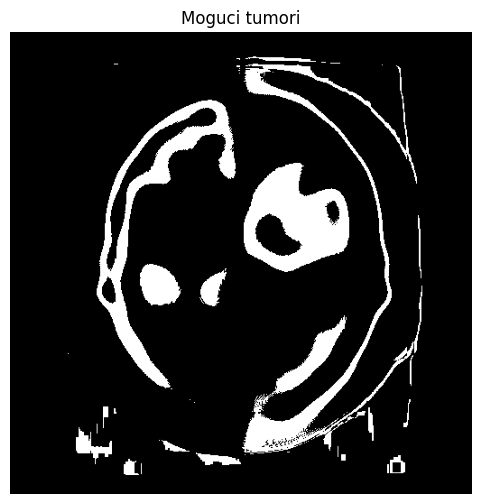

In [5]:

img_path = './data/dataset/images/2.png'
img = Image.open(img_path).convert('L')  # grayscale

#blur
blurred_img = img.filter(ImageFilter.GaussianBlur(radius=10))
img_array = np.array(blurred_img).astype(np.float32)

# Step 2: Find asymmetric bright regions
height, width = img_array.shape
half_width = width // 2

asymmetry_mask = np.zeros_like(img_array, dtype=np.uint8)

for y in range(height):
    for x in range(half_width):
        left_val = img_array[y, x]
        right_val = img_array[y, width - 1 - x]  # mirror along vertical axis

        # If left is at least 10% brighter than right, mark it
        
        top = 1.55
        bot = 1.1
        
        dif1 = left_val/right_val
        dif2 = right_val/left_val
        if dif1 > bot and dif1<top:
            asymmetry_mask[y, x] = 1
        if dif2 > bot and dif2<top:
            asymmetry_mask[y, width - 1 - x] = 1

# Step 3: Visualize asymmetric regions
plt.figure(figsize=(6, 6))
plt.imshow(asymmetry_mask, cmap='gray')
plt.axis('off')
plt.title("Moguci tumori")
plt.show()

In [ ]:
#acccuracy

prediction = asymmetry_mask
maskfr = cv2.imread('./data/dataset/masks/2.png', cv2.IMREAD_GRAYSCALE)


difference = prediction - maskfr
total_pixels = maskfr.size
false_positive = np.sum(difference == 1)
false_negative = np.sum(difference == -1)
true_positive = np.sum(difference - maskfr == -1)
true_negative = total_pixels - (false_positive + false_negative + true_positive)



(512, 512) (512, 512)


'\ndifference = prediction - maskfr\nfalse_positive = np.sum(difference == 1)\nfalse_negative = np.sum(difference == -1)\ntotal_pixels = maskfr.size\ntrue_positive = total_pixels - false_positive - false_negative\n'

In [ ]:
#image from BGR to GRAYSCALE
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#get the threshold
thresh = threshold_otsu(gray_image)
#create a copy of the gray image
bw_img1 = np.copy(gray_image)
#apply the binarization
bw_img1[bw_img1 < thresh] = 0
bw_img1[bw_img1 >= thresh] = 255

plt.imshow(bw_img1)

cv2.imwrite("otsu.png", bw_img1)